# Order of magnitude faster training for image classification: Part II

### _Transfer learning using Inception Package - Cloud Run Experience_
This notebook continues the codifies the capabilities discussed in this [blog post](http://localhost:8081/). In a nutshell, it uses the pre-trained inception model as a starting point and then uses transfer learning to train it further on additional, customer-specific images. For explanation, simple flower images are used. Compared to training from scratch, the time and costs are drastically reduced.

This notebook does preprocessing, training and prediction by calling CloudML API instead of running them in the Datalab container.  The purpose of local work is to do some initial prototyping and debugging on small scale data - often by taking a suitable (say 0.1 - 1%) sample of the full data. The same basic steps can then be repeated with much larger datasets in cloud.

## Setup 

First run the following steps only if you are running Datalab from your local desktop or laptop (not running Datalab from a GCE VM):

1. Make sure you have a GCP project which is enabled for Machine Learning API and Dataflow API.
2. Run "%datalab project set --project [project-id]" to set the default project in Datalab.

If you run Datalab from a GCE VM, then make sure the project of the GCE VM is enabled for Machine Learning API and Dataflow API.

In [4]:
import mltoolbox.image.classification as model
from google.datalab.ml import *

bucket = 'gs://' + datalab_project_id() + '-lab'
preprocess_dir = bucket + '/flowerpreprocessedcloud'
model_dir = bucket + '/flowermodelcloud'
staging_dir = bucket + '/staging'

In [ ]:
!gsutil mb $bucket

## Preprocess
Preprocessing uses a Dataflow pipeline to convert the image format, resize images, and run the converted image through a pre-trained model to get the features or embeddings. You can also do this step using alternate technologies like Spark or plain Python code if you like. 
The %%ml preprocess command simplifies this task. Check out the parameters shown using --usage flag first and then run the command.

If you hit "PERMISSION_DENIED" when running the following cell, you need to enable Cloud DataFlow API (url is shown in error message). 

The DataFlow job usually takes about 20 min to complete.

In [2]:
train_set = CsvDataSet('gs://cloud-datalab/sampledata/flower/train1000.csv', schema='image_url:STRING,label:STRING')
preprocess_job = model.preprocess_async(train_set, preprocess_dir, cloud={'num_workers': 10})
preprocess_job.wait() # Alternatively, you can query the job status by train_job.state. The wait() call blocks the notebook execution.

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Job "preprocess-image-classification-170304-052813" submitted. Click here to track preprocessing job.

## Train
Note that the command remains the same as that in the "local" version.

In [3]:
train_job = model.train_async(preprocess_dir, 30, 1000, model_dir, cloud=CloudTrainingConfig('us-central1', 'BASIC'))
train_job.wait() # Alternatively, you can query the job status by train_job.state. The wait() call blocks the notebook execution.

Job "image_classification_train_170307_002934" submitted. Click here to view cloud log.

Job image_classification_train_170307_002934 completed

Check your job status by running (replace the job id from the one shown above):
```
Job('image_classification_train_170307_002934').describe()
```

Tensorboard works too with GCS path. Note that the data will show up usually a minute after tensorboard starts with GCS path.

In [ ]:
tb_id = TensorBoard.start(model_dir)

## Predict
Deploy the model and run online predictions. The deployment takes about 2 ~ 5 minutes. 

In [21]:
Models().create('flower')
ModelVersions('flower').deploy('beta1', model_dir)

Waiting for operation "projects/bradley-playground/operations/create_flower_beta1-1488494327528"
Done.


Online prediction is currently in alpha, it helps to ensure a warm start if the first call fails.

Predicting...


daisy(0.99997)

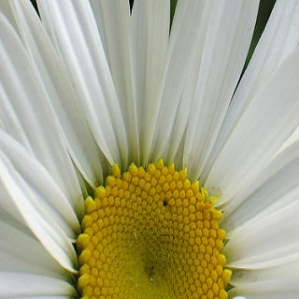

tulips(0.99999)

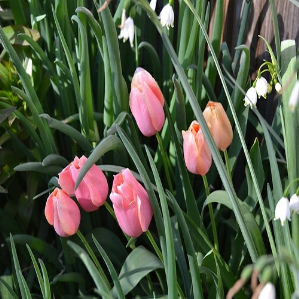

,image_url,label,score
0,gs://cloud-ml-data/img/flower_photos/daisy/152...,daisy,0.999969
1,gs://cloud-ml-data/img/flower_photos/tulips/68...,tulips,0.999988


In [6]:
images = [
    'gs://cloud-ml-data/img/flower_photos/daisy/15207766_fc2f1d692c_n.jpg',
    'gs://cloud-ml-data/img/flower_photos/tulips/6876631336_54bf150990.jpg'
]
# set resize=True to avoid sending large data in prediction request.
model.predict('flower.beta1', images, resize=True, cloud=True)

## Batch Predict

In [ ]:
import google.datalab.bigquery as bq

bq.Dataset('flower').create()
eval_set = CsvDataSet('gs://cloud-datalab/sampledata/flower/eval670.csv', schema='image_url:STRING,label:STRING')
batch_predict_job = model.batch_predict_async(eval_set, model_dir, output_bq_table='flower.eval_results_full',
                                              cloud={'temp_location': staging_dir})
batch_predict_job.wait()

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


Job "batch-predict-image-classification-170307-004521" submitted. Click here to track batch prediction job.

In [1]:
%%bq query --name wrong_prediction

SELECT * FROM flower.eval_results_full WHERE target != predicted

In [2]:
wrong_prediction.execute().result()

image_url,target,predicted,target_prob,predicted_prob
gs://cloud-ml-data/img/flower_photos/daisy/530738000_4df7e4786b.jpg,daisy,roses,0.00432691676542,0.943398058414
gs://cloud-ml-data/img/flower_photos/daisy/10172636503_21bededa75_n.jpg,daisy,roses,0.389928817749,0.591014802456
gs://cloud-ml-data/img/flower_photos/daisy/391364011_5beaaa1ae2_m.jpg,daisy,roses,0.0353457517922,0.558989524841
gs://cloud-ml-data/img/flower_photos/daisy/799964360_7e07a227ea_n.jpg,daisy,tulips,0.0849908292294,0.870252728462
gs://cloud-ml-data/img/flower_photos/daisy/835750256_3f91a147ef_n.jpg,daisy,tulips,2.95653935609e-05,0.995988786221
gs://cloud-ml-data/img/flower_photos/daisy/7320089276_87b544e341.jpg,daisy,dandelion,0.0026037034113,0.806947886944
gs://cloud-ml-data/img/flower_photos/daisy/14088053307_1a13a0bf91_n.jpg,daisy,dandelion,0.0288260094821,0.759018003941
gs://cloud-ml-data/img/flower_photos/daisy/2635314490_e12d3b0f36_m.jpg,daisy,dandelion,0.440836697817,0.461920529604
gs://cloud-ml-data/img/flower_photos/daisy/3337643329_accc9b5426.jpg,daisy,dandelion,0.353675484657,0.601798713207
gs://cloud-ml-data/img/flower_photos/daisy/19019544592_b64469bf84_n.jpg,daisy,dandelion,0.0870867073536,0.883496463299


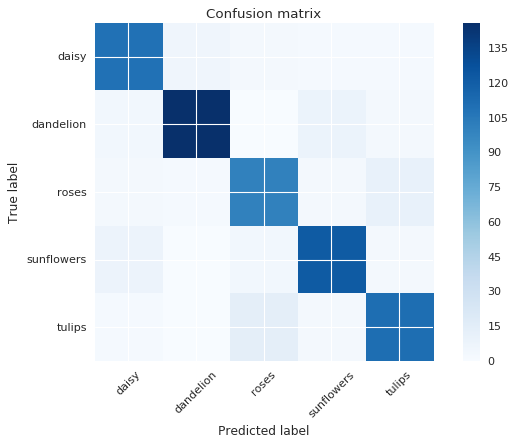

In [5]:
ConfusionMatrix.from_bigquery('flower.eval_results_full').plot()

In [6]:
%%bq query --name accuracy

SELECT
  target,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy
FROM
  flower.eval_results_full
GROUP BY
  target

In [7]:
accuracy.execute().result()

target,correct,total,accuracy
tulips,111,130,0.853846153846
dandelion,146,162,0.901234567901
sunflowers,122,137,0.890510948905
roses,100,119,0.840336134454
daisy,109,122,0.893442622951


In [8]:
%%bq query --name logloss

SELECT feature, AVG(-logloss) as logloss, count(*) as count FROM
(
SELECT feature, CASE WHEN correct=1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss
FROM
(
SELECT
target as feature, 
CASE WHEN target=predicted THEN 1 ELSE 0 END as correct,
target_prob as prob
FROM flower.eval_results_full))
GROUP BY feature

In [9]:
FeatureSliceView().plot(logloss)

## Clean up

In [ ]:
ModelVersions('flower').delete('beta1')
Models().delete('flower')
!gsutil -m rm -r {preprocess_dir}
!gsutil -m rm -r {model_dir}